## Searching best candidate in quarternary alloy compositions for optimal UTS value

In [1]:
import pandas as pd 
import numpy as np
from cbfv.composition import generate_features
import matplotlib.pyplot as plt 
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
import seaborn as sns
from scipy.stats import norm
from sklearn.model_selection import cross_val_score
from utils import bootstrap_estimator,Expected_Improvement
rng_seed = 20

### Reading train and test data .csv files and storing in dataframe

In [2]:
df_train = pd.read_csv('data/model_input/train_ultimatestrength.csv')
df_test = pd.read_csv('data/model_input/test_ultimatestrength.csv')
print('size of train data', len(df_train))
print('size of test data',len(df_test))


size of train data 117
size of test data 27


### Featurization using CBFV and considering only relevant features 

In [3]:
# FEATURIZATION 
X_train_unscaled, y_train, formulae_train, skipped_train = generate_features(df_train,elem_prop='f3_revised',drop_duplicates=False,extend_features=True)
X_test_unscaled, y_test, formulae_test, skipped_test = generate_features(df_test,elem_prop='f3_revised',drop_duplicates=False,extend_features=True)


Processing Input Data: 100%|███████████████| 117/117 [00:00<00:00, 11420.38it/s]


	Featurizing Compositions...


Assigning Features...: 100%|████████████████| 117/117 [00:00<00:00, 6258.00it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████████████| 27/27 [00:00<00:00, 9862.08it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████████████| 27/27 [00:00<00:00, 5096.36it/s]

	Creating Pandas Objects...


### Selecting the features in the form of weighted average for each alloy
$$
  \sum_{i=1}^{n} c_if_i \
$$
  where $c_i$ represents the concentration of each element i (Nb, W, Co etc) in the atom percentage present in   the alloy and $f_i$ represents its elemental property (such as atomic radius, melting point etc.). 




In [4]:
X_train_unscaled_avg = X_train_unscaled[['avg_Atomic_Radius','avg_Pauling_Electronegativity','avg_number_of_valence_electrons','avg_Cohesive_energy_ev_atom',
            'avg_Bulk_modulus_RT_Gpa','avg_Elastic_modulus_RT_Gpa','avg_Shear_modulus_RT_Gpa','avg_Melting_point_(K)','avg_rate_shear_mod_Mpa_perK',
            'avg_Solid_Solubility_atpct','avg_lattice_constant_A','avg_BEC_percm3','avg_Av.Valence_bond_strength_ev','avg_EngelZ_e/a','T']]

X_test_unscaled_avg = X_test_unscaled[['avg_Atomic_Radius','avg_Pauling_Electronegativity','avg_number_of_valence_electrons','avg_Cohesive_energy_ev_atom',
            'avg_Bulk_modulus_RT_Gpa','avg_Elastic_modulus_RT_Gpa','avg_Shear_modulus_RT_Gpa','avg_Melting_point_(K)','avg_rate_shear_mod_Mpa_perK',
            'avg_Solid_Solubility_atpct','avg_lattice_constant_A','avg_BEC_percm3','avg_Av.Valence_bond_strength_ev','avg_EngelZ_e/a','T']]



train_data_avg = X_train_unscaled_avg.join(y_train)
test_data_avg = X_test_unscaled_avg.join(y_test)
total_data_avg = pd.concat([train_data_avg,test_data_avg])
total_data_avg.shape

# Correlation Plot 
# plt.figure(figsize=(20,20))
# cmap = sns.color_palette("coolwarm", as_cmap=True)
# sns.heatmap(total_data_avg.corr(),cmap=cmap)
# plt.show()

# train_data_avg.corr()

print('shape of the features space:',X_train_unscaled_avg.shape)

shape of the features space: (117, 15)


### Scaling using standard scaler 

In [5]:
# Instantiate the standard scaler
scaler = StandardScaler()
# zero mean and unit variance
X_train = scaler.fit_transform(X_train_unscaled_avg)
X_test = scaler.transform(X_test_unscaled_avg)



### Machine Learning Models Performance Evaluation Helper Functions 

In [6]:
################# EVALUATION MATRIX #######################################
def model_evaluation(y_actual,y_predict, label = None,model='None'):
    df = pd.DataFrame([{'mae':mean_absolute_error(y_actual,y_predict),
                        'rmse':mean_squared_error(y_actual,y_predict,squared=False),
                        'r2score':r2_score(y_actual,y_predict),
                        'model':model
                        }])
    if label:
        df.index = [label]
        
    return df

def model_evaluation_result(y_Train,y_train_predict,y_Test,y_test_predict,model='None'):
    result = pd.concat([model_evaluation(y_Train,y_train_predict,'Train',model),
                    model_evaluation(y_Test,y_test_predict, 'Test',model)])
    return result


def plot_model_performance(y_train,y_train_predict,y_test,y_test_predict,r2_train,r2_test):
    plt.figure(figsize=(8,8))
    plt.scatter(y_train,y_train_predict, s=160,alpha=0.7, label='Training Data ($r^2$ ={0:.3f})'.format(r2_train))
    plt.scatter(y_test,y_test_predict,s=160, alpha=0.7, label='Test Data ($r^2$ ={0:.3f})'.format(r2_test))
    # plt.plot(y_test,y_test,'--',dashes=(5, 6),linewidth=2,c='grey',label = 'Ideal Fit')
    plt.axline((0, 0), (1200, 1200), linewidth=2, color='k',linestyle='dashed',label='ideal fit')
    plt.xlabel('Actual Ultimate Tensile Strength (MPa) ', size=16)
    plt.ylabel('Predicted Ultimate Tensile Strength (MPa)',size=16)
    plt.tick_params(labelsize=14)
    plt.xlim((0,1200))
    plt.ylim((0,1200))
    plt.legend(prop={'size': 14})
    plt.minorticks_on()
    plt.tick_params(labelsize=16)
    plt.tick_params(direction='in',which='major', length=15, bottom=True, top=True, left=True, right=True,colors='k')
    plt.tick_params(direction='in',which='minor', length=5, bottom=True, top=True, left=True, right=True,colors='k')


### Gradient Boost Regressor with grid search group kfold

In [7]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV

base_model = GradientBoostingRegressor(random_state=rng_seed, criterion='mse')


param_grid = { 'n_estimators' : [50,100,200],
                'max_depth': [3],
                'max_features': ['auto', 'sqrt', 'log2'],
                'min_samples_split': [5,6,7],
                'min_samples_leaf':[4,5,6],
             }

# Instantiate GroupKfold with no of splits = 5
gkf=GroupKFold(n_splits=5)


gbr_gs= GridSearchCV(
                     base_model,
                     param_grid,
                     scoring='neg_mean_squared_error',
                     cv=gkf
                    )

# Fit training Data 
gbr_gs.fit(X_train,y_train,groups=formulae_train)

# Best Estimator
print(gbr_gs.best_estimator_)

gbr_gs_best=gbr_gs.best_estimator_


gbr_gs_best.fit(X_train,y_train)

# predict y_train and y_test
y_train_predict=gbr_gs_best.predict(X_train)
y_test_predict=gbr_gs_best.predict(X_test)

r2_train = r2_score(y_train,y_train_predict)
r2_test = r2_score(y_test,y_test_predict)
#print(gbr_gs_best)

print('r2score_train:',r2_score(y_train,y_train_predict))
print('r2score_test:',r2_score(y_test,y_test_predict))


GradientBoostingRegressor(criterion='mse', max_features='auto',
                          min_samples_leaf=6, min_samples_split=5,
                          n_estimators=50, random_state=20)
r2score_train: 0.9821655111121639
r2score_test: 0.8374028340428461


### Performance Evaluation Gradient Boost Regressor

             mae        rmse   r2score   model
Train  18.150987   24.524460  0.982166  gbr_GS
Test   57.420002  103.663852  0.837403  gbr_GS
****************************************************************************
                       feature_name  importance
14                                T    0.846733
11                   avg_BEC_percm3    0.053563
1     avg_Pauling_Electronegativity    0.025993
5        avg_Elastic_modulus_RT_Gpa    0.016768
4           avg_Bulk_modulus_RT_Gpa    0.014055
0                 avg_Atomic_Radius    0.011482
10           avg_lattice_constant_A    0.008433
12  avg_Av.Valence_bond_strength_ev    0.007485
3       avg_Cohesive_energy_ev_atom    0.006133
8       avg_rate_shear_mod_Mpa_perK    0.003039


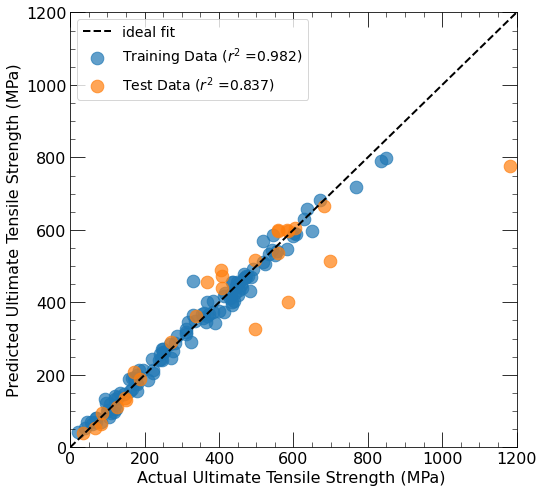

In [8]:
############## EVALUATION ##########################################################

print(model_evaluation_result(y_train,y_train_predict,y_test,y_test_predict,'gbr_GS'))
print('****************************************************************************')
feature_imp_df = pd.concat([pd.Series(X_train_unscaled_avg.columns),
                            pd.Series(gbr_gs_best.feature_importances_)], 
                           axis = 1)
feature_imp_df.columns=['feature_name','importance'];
print(feature_imp_df.sort_values('importance',ascending=False)[0:10])
feature_imp_df.index = feature_imp_df.feature_name

#feature_imp_df.sort_values('importance', ascending=False)[0:12].plot(kind="bar", figsize=(16,4))

plot_model_performance(y_train,y_train_predict,y_test,y_test_predict,r2_train,r2_test)

### Estimating mean and standard deviation using the helper function bootstrap_estimator

In [9]:
## Using the hyperparmeters of the best estimator of GBR model 
from sklearn.ensemble import GradientBoostingRegressor
# parameters = dict(criterion='mse', max_features='auto',
#                           min_samples_leaf=6, min_samples_split=5,
#                           n_estimators=50, random_state=20
    
#                  )


# parameters = dict(criterion='mse', max_features='sqrt',
#                           min_samples_leaf=6, min_samples_split=5,
#                           n_estimators=200, random_state=20)

# gbr = GradientBoostingRegressor(**parameters)


mean , std  = bootstrap_estimator(gbr_gs_best, X_train, y_train, X_test, n_iter=1000)


print(pd.DataFrame([mean,std]))

mean_train , std_train  = bootstrap_estimator(gbr_gs_best, X_train, y_train, X_train, n_iter=1000)


           0           1          2          3          4           5   \
0  519.765545  214.770306  90.351758  74.283411  61.672422  580.302139   
1   36.707147   25.302128  14.891551  15.579729  16.053421   25.995534   

           6           7           8           9   ...          17  \
0  461.369881  427.152165  277.580745  130.114036  ...  587.318097   
1   18.824960   18.347972   22.701636   15.605883  ...   58.016300   

           18          19          20          21          22          23  \
0  574.268174  565.772100  560.410292  516.555430  487.674618  401.529680   
1   62.892870   63.580435   68.628680   61.596693   58.295213   58.657113   

           24          25          26  
0  320.618840  225.828505  149.323575  
1   33.126829   29.565811   23.065080  

[2 rows x 27 columns]


### plotting the uncertainties for the test data 

r2 score test data: 0.7969220771872714
r2 score train data: 0.9729175505862897


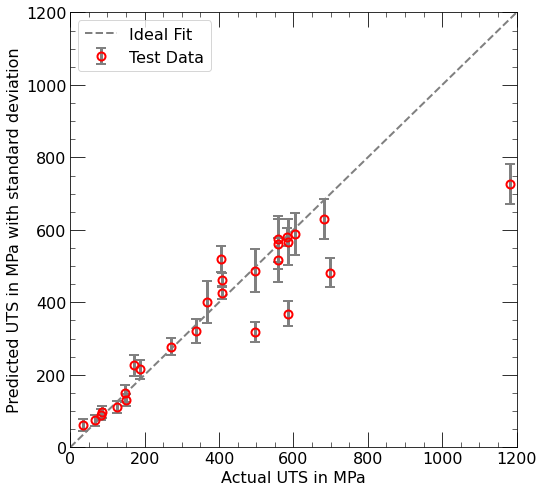

In [10]:
plt.figure(figsize=(8,8))

plt.errorbar(y_test,mean,yerr=std,ecolor = 'grey',mfc='None', mec='red',mew=2,elinewidth= 3,ls = 'none',marker='o',markersize=8,solid_capstyle='projecting', capsize=5,label='Test Data')

plt.xlabel('Actual UTS in MPa',fontsize=16)
plt.ylabel('Predicted UTS in MPa with standard deviation',fontsize=16)
plt.axline((0, 0), (1200, 1200), linewidth=2, color='grey',linestyle='dashed',label='Ideal Fit')
plt.legend(fontsize=16)
plt.xlim(0,1200)
plt.ylim(0,1200)

plt.minorticks_on()
plt.tick_params(labelsize=16)
plt.tick_params(direction='in',which='major', length=15, bottom=True, top=True, left=True, right=True,colors='k')
plt.tick_params(direction='in',which='minor', length=5, bottom=True, top=True, left=True, right=True,colors='k')

print('r2 score test data:',r2_score(y_test,mean))
print('r2 score train data:',r2_score(y_train,mean_train))   
# mean_squared_error(y_test,mean,squared=False)
# mean_absolute_error(y_test,mean)

### Plotting the uncertainties for the train data 

r2 score test data: 0.7969220771872714
r2 score train data: 0.9729175505862897


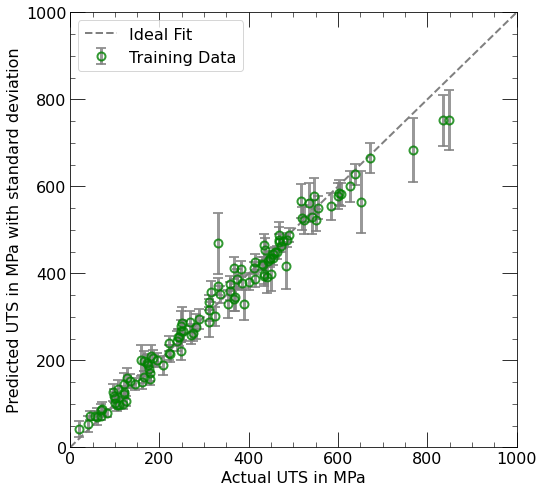

In [11]:
plt.figure(figsize=(8,8))

plt.errorbar(y_train,mean_train,yerr=std_train,mfc='None',mec='green',mew=2,ecolor = 'grey',alpha=0.8, elinewidth= 3,ls = 'none',marker='o',markersize=8,solid_capstyle='projecting', capsize=5,label='Training Data')
plt.xlabel('Actual UTS in MPa',fontsize=16)
plt.ylabel('Predicted UTS in MPa with standard deviation',fontsize=16)
plt.axline((0, 0), (1000, 1000), linewidth=2, color='grey',linestyle='dashed',label='Ideal Fit')
plt.legend(fontsize=16)

plt.minorticks_on()
plt.tick_params(labelsize=16)
plt.tick_params(direction='in',which='major', length=15, bottom=True, top=True, left=True, right=True,colors='k')
plt.tick_params(direction='in',which='minor', length=5, bottom=True, top=True, left=True, right=True,colors='k')


plt.xlim(0,1000)
plt.ylim(0,1000)
print('r2 score test data:',r2_score(y_test,mean))
print('r2 score train data:',r2_score(y_train,mean_train))  

# mean_squared_error(y_test,mean,squared=False)
# mean_absolute_error(y_test,mean)

### Reading .csv file of composition (candidate search space)  and converting weight percent to atom percent

In [12]:
from convesrion_weightpct_atpct import wtpct_To_atpct
df_test_composition = pd.read_csv('data/compositions_test_24degc_allcombinations.csv')
df_test_composition['formula']=[wtpct_To_atpct(i) for i in df_test_composition.wt_pct]
df_test_total = df_test_composition[['formula','T','target']]
#df_test_total['T']=1300
df_test_total.head()



,formula,T,target
0,Nb80.9B7.2C6.4N5.5,24,0
1,Nb76.4B6.8C6.2N10.6,24,0
2,Nb72.4B6.5C5.9N15.2,24,0
3,Nb68.7B6.3C5.7N19.4,24,0
4,Nb65.3B6.0C5.4N23.3,24,0


In [13]:
print(len(df_test_total))
df_test_final = df_test_total
df_test_final.tail()

1666625


,formula,T,target
1666620,Nb60.8Ta14.2W14.0Re11.0,24,0
1666621,Nb59.8Ta14.3W14.1Re11.8,24,0
1666622,Nb58.9Ta14.4W14.2Re12.6,24,0
1666623,Nb57.9Ta14.5W14.3Re13.4,24,0
1666624,Nb56.9Ta14.6W14.4Re14.2,24,0


### Generate Features for the search space using CBFV

In [14]:
X_test_comp, y_test_comp, formulae_test_comp, skipped_train = generate_features(df_test_final,elem_prop='f3_revised',drop_duplicates=False,extend_features=True)
#X_test_comp[110000:160004]

Processing Input Data: 100%|███████| 1666625/1666625 [01:24<00:00, 19838.39it/s]


	Featurizing Compositions...


Assigning Features...: 100%|███████| 1666625/1666625 [01:58<00:00, 14071.13it/s]


	Creating Pandas Objects...


### Using only weighted average values 

In [15]:
X_test_comp_avg  = X_test_comp[['avg_Atomic_Radius','avg_Pauling_Electronegativity','avg_number_of_valence_electrons','avg_Cohesive_energy_ev_atom',
            'avg_Bulk_modulus_RT_Gpa','avg_Elastic_modulus_RT_Gpa','avg_Shear_modulus_RT_Gpa','avg_Melting_point_(K)','avg_rate_shear_mod_Mpa_perK',
            'avg_Solid_Solubility_atpct','avg_lattice_constant_A','avg_BEC_percm3','avg_Av.Valence_bond_strength_ev','avg_EngelZ_e/a','T']]



In [16]:
## to test if there is any null value 
pd.DataFrame(X_test_comp_avg).isnull().sum()

avg_Atomic_Radius                  0
avg_Pauling_Electronegativity      0
avg_number_of_valence_electrons    0
avg_Cohesive_energy_ev_atom        0
avg_Bulk_modulus_RT_Gpa            0
avg_Elastic_modulus_RT_Gpa         0
avg_Shear_modulus_RT_Gpa           0
avg_Melting_point_(K)              0
avg_rate_shear_mod_Mpa_perK        0
avg_Solid_Solubility_atpct         0
avg_lattice_constant_A             0
avg_BEC_percm3                     0
avg_Av.Valence_bond_strength_ev    0
avg_EngelZ_e/a                     0
T                                  0
dtype: int64

### Normalization and Prediction
### for predicting mean and std deviation of candidate space we have used entire dataset for training keeping the hyperparameters same for the model 

In [17]:
X_train_all = np.concatenate((X_train_unscaled_avg,X_test_unscaled_avg),axis = 0)
y_train_all = np.concatenate((y_train,y_test),axis=0)

scaler = StandardScaler()
X_train_all_scaled = scaler.fit_transform(X_train_all) ## fit and transform training data and 

X_test_comp_avg_scaled  = scaler.transform(X_test_comp_avg) # transform test data
print('maximum value of the UTS in the experimental data:',y_train_all.max())


maximum value of the UTS in the experimental data: 1182.49


In [18]:
# Estimating mean and standard deviation for all the available experimental data
mean_train_all , std_train_all  = bootstrap_estimator(gbr_gs_best, X_train_all_scaled, y_train_all, X_train_all_scaled, n_iter=1000)


r2 score train data: 0.9672985241174575


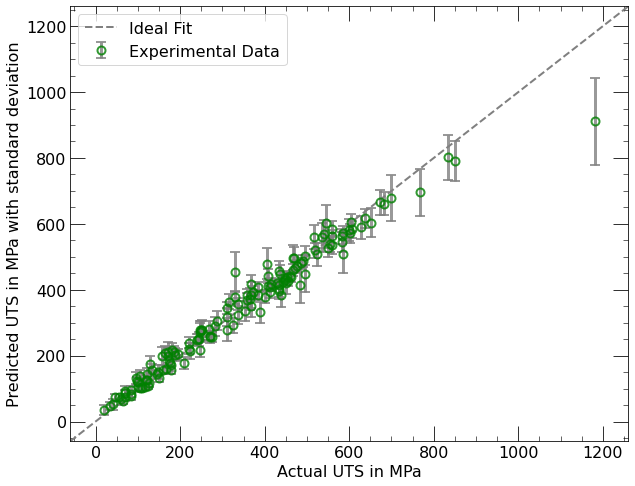

In [19]:
plt.figure(figsize=(10,8))
plt.errorbar(y_train_all,mean_train_all,yerr=std_train_all,mfc='None',mec='green',mew=2,ecolor = 'grey',alpha=0.8, elinewidth= 3,ls = 'none',marker='o',markersize=8,solid_capstyle='projecting', capsize=5,label='Experimental Data')
#plt.errorbar(y_train,mean_train,yerr=std_train,ecolor = 'grey', elinewidth= 3,c ='red',ls = 'none',marker='o',markersize=8,solid_capstyle='projecting', capsize=5,label='UTS (MPa) train')

plt.xlabel('Actual UTS in MPa',fontsize=16)
plt.ylabel('Predicted UTS in MPa with standard deviation',fontsize=16)
plt.axline((0, 0), (1200, 1200), linewidth=2, color='grey',linestyle='dashed',label='Ideal Fit')
plt.legend(fontsize=16)

plt.minorticks_on()
plt.tick_params(labelsize=16)
plt.tick_params(direction='in',which='major', length=15, bottom=True, top=True, left=True, right=True,colors='k')
plt.tick_params(direction='in',which='minor', length=5, bottom=True, top=True, left=True, right=True,colors='k')


print('r2 score train data:',r2_score(y_train_all,mean_train_all))   
# mean_squared_error(y_test,mean,squared=False)
# mean_absolute_error(y_test,mean)

### Calculating EI

In [20]:
ei,predicted_property,std = Expected_Improvement(X_test_comp_avg_scaled, X_train_all_scaled, y_train_all,gbr_gs_best,xi=0.01)


### Saving the Predicted value and EI in .csv file


In [23]:
df_predict = pd.DataFrame({"ei":ei, "predicted_property":predicted_property, "std":std})
df_predict_final = df_test_final.join(df_predict)
df_predict_final['wt_pct'] = df_test_composition['wt_pct']

df_predict_final_sorted = df_predict_final.sort_values('ei',ascending=False)
#df_predict_final_sorted.to_csv('data/model_output/paper_UTS_quarterany.csv')
df_predict_final_sorted[0:10]


,formula,T,target,ei,predicted_property,std,wt_pct
1546644,Nb87.0Zr1.1Hf0.6W11.3,24,0,1.013167,911.427105,132.884163,Nb78Zr1Hf1W20
1562683,Nb86.4Zr1.1Ta1.7W10.8,24,0,1.010320,909.526553,133.615457,Nb77Zr1Ta3W19
1562703,Nb85.7Zr1.1Ta2.3W10.8,24,0,0.926328,912.397481,130.691755,Nb76Zr1Ta4W19
1562644,Nb87.0Zr1.1Ta0.6W11.3,24,0,0.916319,914.503917,129.613406,Nb78Zr1Ta1W20
1635044,Nb86.8Hf1.2Ta0.6W11.4,24,0,0.905452,914.254221,129.484033,Nb77Hf2Ta1W20
1563064,Nb85.2Zr2.3Ta1.2W11.3,24,0,0.904750,913.160659,129.917591,Nb76Zr2Ta2W20
1635103,Nb85.5Hf1.2Ta2.3W10.9,24,0,0.902175,912.307945,130.211746,Nb75Hf2Ta4W19
1562684,Nb85.7Zr1.1Ta1.7W11.4,24,0,0.899347,912.683584,129.996748,Nb76Zr1Ta3W20
1635464,Nb85.5Hf1.8Ta1.2W11.5,24,0,0.883337,913.317179,129.389695,Nb75Hf3Ta2W20
1635444,Nb86.2Hf1.8Ta0.6W11.5,24,0,0.883337,913.317179,129.389695,Nb76Hf3Ta1W20
